In [4]:
#from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile
import soundfile


#from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa
#drive.mount('/content/drive')

In [5]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import time
import torch.optim as optim


In [66]:
timeseries_length = 461


In [361]:
def feature_chromagram(waveform, sample_rate):
    # STFT computed here explicitly; mel spectrogram and MFCC functions do this under the hood
    stft_spectrogram=np.abs(librosa.stft(waveform))
    # Produce the chromagram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate,hop_length=512,n_fft=2048).T,axis=0)
    return chromagram

def feature_melspectrogram(waveform, sample_rate):
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128, fmax=sample_rate, hop_length=512,n_fft=2048).T,axis=0) ###
    return melspectrogram

def feature_mfcc(waveform, sample_rate):
    # Compute the MFCCs for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # 40 filterbanks = 40 coefficients
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40).T ,axis = 0)
    return mfc_coefficients



def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
    p = winLen*fs
    frame_length = int(2**int(p-1).bit_length())
    hop_length = frame_length//2
    f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs, frame_length=frame_length,hop_length=hop_length)
    return f0,voiced_flag



def get_features(file):
    # load an individual soundfile
     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        # compute features of soundfile
        #chromagram = feature_chromagram(waveform, sample_rate)
        #melspectrogram = feature_melspectrogram(waveform, sample_rate)
        mfc_coefficients = feature_mfcc(waveform, 1024)

        # my added features
        #######
        #y = waveform
        #sr = sample_rate
        #stft_=np.abs(librosa.stft(waveform))

        #cent = np.mean( librosa.feature.spectral_centroid(y=y, sr=sr,hop_length=512,n_fft=2048).T, axis=0)
        #contrast = np.mean( librosa.feature.spectral_contrast(S=stft_, sr=sr,hop_length=512,n_fft=2048).T, axis=0)
        #tonnetz = np.mean( librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sample_rate ,hop_length=512).T,axis=0)#
        #rms = np.mean( librosa.feature.rms(y=y,frame_length=2048 ,hop_length=512).T, axis=0)
        #spec_bw = np.mean( librosa.feature.spectral_bandwidth(y=y, sr=sr ,n_fft=2048, hop_length=512).T, axis=0)
        #rolloff = np.mean( librosa.feature.spectral_rolloff(y=y, sr=sr ,n_fft=2048, hop_length=512).T, axis=0)
        #zcr = np.mean( librosa.feature.zero_crossing_rate(y, frame_length=2048, hop_length=512).T, axis=0) 
        #######

        #feature_matrix=np.array([])
        # use np.hstack to stack our feature arrays horizontally to create a feature matrix
        #feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients , cent, contrast, rms, spec_bw, rolloff, zcr))
        #feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients , cent, contrast, rms, spec_bw, rolloff, zcr))
        
        return mfc_coefficients

In [362]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
    X,y =[],[]
    
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }
    
    
    for file in tqdm(files):
        file = file.replace("\\", "/")
        fileID = file.split("/")[-1]
        #print(fileID)
        yi = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
        label = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
        if onlySingleDigit and yi>9:
            continue
        else:
            fs = None # if None, fs would be 22050
            x, fs = librosa.load(file,sr=fs)
            if scale_audio: x = x/np.max(np.abs(x))
            f0, voiced_flag = getPitch(x,fs,winLen=0.02)

            power = np.sum(x**2)/len(x)
            pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
            pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
            voiced_fr = np.mean(voiced_flag)

            #added 
            features = get_features(file)

            #xi = [power,pitch_mean,pitch_std,voiced_fr]

            #xi = np.hstack((power,pitch_mean,pitch_std,voiced_fr,features))
           
            data["mfcc"].append(features)
            data["labels"].append(label) 
            
            X.append(features)
            y.append(label)
    return np.array(X),np.array(y) , data

In [363]:
labels = pd.read_csv('./Data/MLEnd/trainingMLEnd.csv')
labels


,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,question
1,0000001.wav,2,S88,excited
2,0000002.wav,70,S5,neutral
3,0000003.wav,2,S85,bored
4,0000004.wav,4,S30,excited
...,...,...,...,...
19995,0019995.wav,90,S163,excited
19996,0019996.wav,10,S99,question
19997,0019997.wav,90,S46,question
19998,0019998.wav,19,S13,neutral


In [365]:
files = glob.glob("./Data/MLEnd/training/Training/*.wav" )


X,y,data = getXy(files[:200],labels_file=labels,scale_audio=True, onlySingleDigit=True)

#a,b = getXy(files[:1000],labels_file=labels,scale_audio=True, onlySingleDigit=True)


100%|██████████| 200/200 [00:27<00:00,  7.31it/s]


In [322]:
# convert lists to numpy arrays
a = np.array(data["mfcc"])
b = np.array(data["labels"])

print("Data succesfully loaded!")

Data succesfully loaded!


<ipython-input-322-92b01a96d9bc>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array(data["mfcc"])


In [318]:
data["mfcc"]

[array([[-5.7429938e+02,  2.8409851e+01,  1.5847057e+01, ...,
         -1.7315575e+00, -1.1718874e+00,  7.7907488e-02],
        [-5.7059277e+02,  3.5172012e+01,  2.3068073e+01, ...,
         -1.7773646e-01, -8.1770515e-01,  1.5729135e-01],
        [-5.7028870e+02,  3.5303719e+01,  2.3049780e+01, ...,
          6.1442339e-01,  8.0290800e-01,  2.7332509e-01],
        ...,
        [-5.7446790e+02,  2.2365139e+01, -9.9030805e-01, ...,
          4.3709340e+00,  1.3669726e-01, -5.7857428e+00],
        [-5.7374213e+02,  2.1926739e+01, -2.4308162e+00, ...,
          2.1274774e+00, -1.2692744e+00, -5.9273329e+00],
        [-5.7448956e+02,  2.1730593e+01, -2.2426517e+00, ...,
          4.3621570e-01, -3.5869958e+00, -7.9401684e+00]], dtype=float32),
 array([[-3.3933929e+02,  7.0770531e+01,  2.3333485e+01, ...,
         -1.0397642e+00, -5.1319795e+00, -2.4433820e+00],
        [-3.3561194e+02,  6.8432190e+01,  2.3275837e+01, ...,
          4.2554557e-01, -3.8512268e+00,  1.4298996e-01],
        [-

In [321]:
X[0].shape

(38, 40)

In [296]:
mfc_coefficients_df = pd.DataFrame(X) # make it pretty for display
#print(mfc_coefficients.shape)
mfc_coefficients_df

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-615.650696,76.079506,14.183249,2.055386,-14.936810,-1.414083,-1.754389,0.165803,-7.749091,-12.595222,...,-1.933366,-1.750039,-0.186601,-2.058716,-1.609681,0.320641,0.080657,0.189060,-1.025558,0.140107
1,-326.022552,77.891136,-19.062094,21.070469,3.021273,2.141247,-4.021226,-2.159979,-7.786098,-1.169007,...,-5.737593,-0.895549,-5.064484,-3.337824,-2.517254,0.388113,0.156611,6.130723,3.563455,2.384612
2,-452.457703,97.484871,25.988503,21.277096,17.212198,12.850103,17.728901,7.606271,1.237578,6.582763,...,3.685145,5.244210,-2.115300,-4.195786,-0.733305,-0.113300,0.245128,1.360190,0.303358,2.322390
3,-359.200897,97.792557,10.582139,9.163195,14.097530,-0.814324,2.324103,1.685807,-8.576827,5.498129,...,2.693418,9.689104,9.157495,10.718136,3.795865,3.847458,-4.055942,3.164512,-2.483745,0.586097
4,-366.935760,71.676834,6.974797,15.992706,-2.613075,5.743100,-7.719093,2.960069,-1.692857,0.917281,...,1.531407,0.877668,0.345242,-1.409792,3.051754,0.115508,0.033642,0.763676,-0.201704,0.473508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,-540.817261,76.246811,-26.107344,27.022938,6.650873,6.945522,-10.974952,-4.565447,-3.458540,-4.153194,...,2.803157,-2.053555,-7.871626,-2.573307,1.366891,-6.388124,-4.260029,-4.250887,-5.435730,-1.537620
71,-562.344666,73.371803,25.869078,36.976166,7.503856,-9.559481,-14.135124,3.799800,-3.244669,1.665445,...,-0.522597,-1.985590,-3.349240,-3.930804,-3.185094,-1.798284,-4.591371,-0.710731,-3.418185,-0.746057
72,-613.265381,102.559166,11.703487,19.697742,9.399258,7.155128,18.506426,5.792678,-5.529737,5.535159,...,-2.328252,0.241480,0.257710,0.188153,-4.000965,2.566364,1.713233,1.483127,1.580761,1.374729
73,-474.982513,62.263802,-45.670948,3.732790,-32.395390,-18.962099,-18.980059,-10.544338,-12.919526,-14.647248,...,5.598455,-1.415365,-0.180594,-6.514090,2.413891,-0.571339,1.009896,1.963453,0.199370,2.331960


In [218]:
X[7][4].shape

(40,)

In [366]:
#a.shape[1]

In [367]:
#a.shape[2]

In [47]:
#import math
#hop_length = 512

#timeseries_length_list = []
#for file in files[:20000]:
#    #print("Loading " + str(file))
#    y, sr = librosa.load(file)
#    timeseries_length_list.append(math.ceil(len(y) / hop_length))
    
#max(timeseries_length_list)

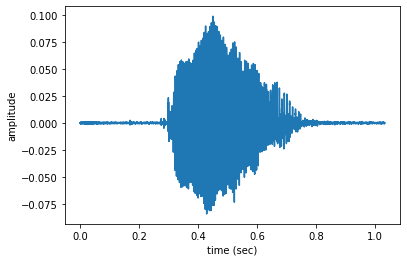

In [347]:
n=10
fs = None # Sampling frequency. If None, fs would be 22050
x, fs = librosa.load(files[n],sr=22050)
t = np.arange(len(x))/fs

plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))

In [357]:
#n=0
x, fs = librosa.load(files[900],sr=10024)
print('This audio signal has', len(x)/512, 'samples')

This audio signal has 20.458984375 samples


In [332]:
print(type(x))
print(x.shape)
print(x)

<class 'numpy.ndarray'>
(892,)
[ 3.29750992e-06 -5.17201261e-05 -6.77703647e-05 -4.36939736e-05
 -4.10199427e-05 -3.48738395e-05 -1.94265122e-05 -3.96675605e-05
  3.09599673e-05 -2.46513791e-05 -7.46270962e-06  6.11778887e-05
 -3.94798990e-05  3.91688009e-05 -1.38525602e-05  1.98578691e-05
 -4.71730345e-05  1.95498978e-05 -1.86201778e-05 -7.09857268e-05
  9.11193420e-05 -1.87713638e-04  9.79933611e-05 -7.99932895e-05
 -1.29272608e-04  1.12584057e-04 -1.66803919e-04  6.64644103e-05
 -5.60729786e-05 -8.45314389e-06  1.25766610e-06 -9.55104842e-05
 -2.18514060e-06 -9.55488649e-05 -6.22637745e-05 -8.64547401e-05
  2.04081662e-05 -9.33234114e-05  3.38512873e-05  4.50302396e-05
 -8.90176161e-05  9.40471145e-05 -8.50612632e-05 -4.53881057e-06
 -3.40434817e-05 -5.18090492e-05  2.80167242e-05 -4.87188299e-05
  5.75313206e-05 -1.84668443e-05  3.65513115e-05  2.23452116e-05
  5.71452438e-06  1.98236630e-05  1.09314979e-05 -2.53213625e-06
 -1.82576641e-05  6.60749938e-05 -1.17198026e-04  5.2149065

In [335]:
data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

m =librosa.feature.mfcc(y=x, sr=fs , n_mfcc=40,hop_length=512).T
m 

array([[-1.66617264e+02, -3.58742485e+01, -1.13423462e+02,
         1.83360964e-01, -7.47923279e+01,  1.44164810e+01,
        -3.10679207e+01,  4.12481079e+01,  2.35524826e+01,
         4.34162598e+01, -3.56099167e+01,  2.25454254e+01,
        -1.83605080e+01,  7.26098585e+00, -3.23829041e+01,
        -1.29063034e+01,  1.19893961e+01,  2.03136864e+01,
        -9.97757816e+00, -4.31601095e+00, -9.20925331e+00,
        -1.16092891e-01, -8.47637177e+00,  5.76494122e+00,
         2.15572000e-01,  2.05333023e+01, -1.02934515e+00,
         1.18769455e+00, -4.28602362e+00, -2.04669857e+00,
        -1.10488284e+00, -6.20224476e+00, -2.14317262e-01,
        -7.23816514e-01,  7.04894257e+00, -2.27924776e+00,
        -2.92913485e+00, -3.50767374e+00,  6.56385958e-01,
        -2.63832951e+00],
       [-1.58951675e+02, -4.04888496e+01, -1.11644005e+02,
         1.98681283e+00, -7.45193024e+01,  1.25284319e+01,
        -3.25442123e+01,  4.19790344e+01,  2.26255398e+01,
         4.54487152e+01, -3.26

In [287]:
m.shape

(40,)

In [167]:
data["mfcc"].append(m.tolist())

In [168]:
m.tolist()

[[-671.5302734375,
  10.528260231018066,
  7.362443923950195,
  3.828178882598877,
  1.1961519718170166,
  -0.12163373827934265,
  -0.3854006230831146,
  -0.04684656858444214,
  0.47191253304481506,
  0.7829121351242065,
  0.6501057744026184,
  0.18549805879592896,
  -0.24051843583583832,
  -0.4214818775653839,
  -0.5765478610992432,
  -1.0531412363052368,
  -1.791550874710083,
  -2.2543041706085205,
  -1.9773926734924316,
  -1.0927824974060059,
  -0.17676043510437012,
  0.3858046233654022,
  0.7478185296058655,
  1.2913801670074463,
  2.121812582015991,
  2.98258113861084,
  3.580685615539551,
  3.8113558292388916,
  3.6418042182922363,
  2.9710545539855957,
  1.782763957977295,
  0.3807980418205261,
  -0.7245474457740784,
  -1.2448545694351196,
  -1.3236138820648193,
  -1.2313377857208252,
  -0.9531269073486328,
  -0.2664594352245331,
  0.7403417825698853,
  1.405277967453003],
 [-669.0040283203125,
  14.556802749633789,
  12.398038864135742,
  9.700790405273438,
  7.306818962097168,

mfc_coefficients=  np.mean(librosa.feature.melspectrogram(y=x, sr=fs, n_mels=128, fmax=fs, hop_length=512,n_fft=2048).T,axis=0) ###

mfc_coefficients_df = pd.DataFrame(mfc_coefficients) # make it pretty for display
print(mfc_coefficients.shape)
mfc_coefficients_df

In [ ]:
#audio_data = concatenate( (audio_data, zeros( (51 - audio_data.shape[0], 36) )))


In [368]:
#data = np.zeros((len(files[:13] ), 190,timeseries_length), dtype=np.float64)
#data.shape

In [ ]:
#if x.shape[0] < 51:
#    audio_data = concatenate( (audio_data, zeros( (51 - audio_data.shape[0], 36) )))
#audio_data

data = np.zeros( (len(list_of_audiofiles), self.timeseries_length, 33), dtype=np.float64 )

In [18]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif#

#X.shape
X_new = SelectKBest(mutual_info_classif, k=190).fit_transform(X, y)
#X_new = SelectKBest(mutual_info_classif, k=150).fit_transform(a, b)

X_new.shape

(337, 190)

In [75]:
print(f'\nAudio samples represented: {X_new.shape[0]}')
print(f'Numerical features extracted per sample: {X_new.shape[1]}')
features_df = pd.DataFrame(X_new) # make it pretty for display
features_df


Audio samples represented: 337
Numerical features extracted per sample: 190


,0,1,2,3,4,5,6,7,8,9,...,180,181,182,183,184,185,186,187,188,189
0,0.010129,208.882834,118.829623,0.215278,0.753131,0.766886,0.749057,0.671027,0.634170,0.670543,...,12.066502,13.726420,15.600197,15.085901,15.386061,19.041806,0.009657,2197.995732,4693.939209,0.159003
1,0.035339,157.289085,31.784415,0.293333,0.583537,0.643321,0.677088,0.669812,0.709702,0.740893,...,13.944263,15.772536,16.208509,17.446751,17.795718,27.592407,0.031027,2434.352641,5335.701069,0.155646
2,0.013676,134.964540,4.520547,0.084507,0.677341,0.748570,0.695867,0.597716,0.595714,0.726472,...,12.323731,16.377326,15.793714,20.858538,21.230001,19.016606,0.031680,1446.833328,1627.869907,0.027166
3,0.052517,181.944641,40.719889,0.494253,0.569682,0.537822,0.540425,0.537556,0.533592,0.509157,...,15.977014,20.075173,18.970150,17.982028,19.588298,25.813768,0.078083,1994.697128,3658.686967,0.105957
4,0.027461,109.742686,18.208426,0.120000,0.704168,0.769274,0.750523,0.715473,0.715584,0.750014,...,11.006136,14.597893,15.629837,15.968503,17.372982,28.002703,0.073354,1915.549197,4090.016602,0.118665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,0.069766,169.263786,37.915774,0.654545,0.574586,0.549301,0.550144,0.530207,0.498767,0.489934,...,17.387905,22.698205,17.053378,19.010217,19.918645,26.298124,0.081792,2197.950735,3885.568626,0.046671
333,0.026559,237.843853,28.992245,0.306306,0.607536,0.571724,0.467266,0.450119,0.520315,0.563011,...,18.214393,18.488736,20.327478,20.695527,17.633616,27.010899,0.033097,1308.785867,2248.681641,0.071995
334,0.070466,218.394519,11.606973,0.357143,0.571892,0.471446,0.463473,0.476342,0.409125,0.290854,...,18.132604,16.945738,15.973385,18.100101,16.292020,31.573117,0.093979,3010.964264,7461.447144,0.280055
335,0.027305,105.855202,4.478636,0.406593,0.595436,0.627027,0.647870,0.764208,0.754700,0.590106,...,14.004776,17.261628,14.990729,19.036370,19.929089,28.120640,0.026049,2568.852787,5349.596637,0.126274


In [20]:
intonation_list = np.unique(y)
intonation_list

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

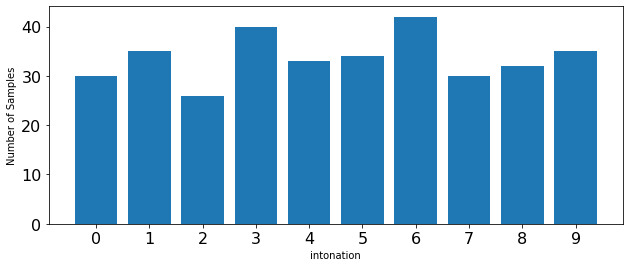

In [21]:
# plot emotions
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
intonation_list, count = np.unique(y, return_counts=True)
plt.bar(x=range(10), height=count)
plt.xticks(ticks=range(10), labels = [intonation for intonation in intonation_list],fontsize=10)
plt.xlabel('intonation')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()

In [22]:
# If nan sample, remove them
if np.sum(np.isnan(X)):
    idx = np.isnan(X).sum(1)>0
    X = X[~idx]
    y = y[~idx]
print(np.sum(np.isnan(X)))

0


In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
#features_scaled = X
#features_scaled = a
features_scaled = X_new
features_scaled = scaler.fit_transform(features_scaled)

#scaler = MinMaxScaler()
# keep our unscaled features just in case we need to process them alternatively
#features_minmax = features
#features_minmax = scaler.fit_transform(features_minmax)

In [24]:
features_scaled_df = pd.DataFrame(features_scaled) # make it pretty for display
features_scaled_df

,0,1,2,3,4,5,6,7,8,9,...,180,181,182,183,184,185,186,187,188,189
0,-0.901676,0.407766,4.004006,-0.639382,0.868607,1.122453,0.927837,0.189766,-0.104418,0.284597,...,-1.285809,-1.515808,-0.397705,-1.390885,-1.360630,-1.110071,-0.788302,-0.051868,0.021292,0.294187
1,0.753449,-0.247745,0.305483,-0.150474,-0.807047,-0.047248,0.274830,0.178877,0.513304,0.881926,...,-0.434549,-0.599894,-0.112589,-0.113552,-0.240858,1.010857,0.027917,0.565335,0.481550,0.253675
2,-0.668782,-0.531383,-0.852951,-1.458475,0.119776,0.949063,0.445221,-0.466998,-0.418926,0.759478,...,-1.169197,-0.329169,-0.307004,1.732388,1.355059,-1.116322,0.052862,-2.013393,-2.177630,-1.296705
3,1.881196,0.065510,0.685148,1.108002,-0.943942,-1.045935,-0.965160,-1.005956,-0.926981,-1.085706,...,0.486973,1.326119,1.181792,0.176058,0.592156,0.569675,1.825211,-0.582746,-0.721170,-0.345926
4,0.236219,-0.851833,-0.271357,-1.236162,0.384830,1.145051,0.941133,0.587940,0.561412,0.959369,...,-1.766512,-1.125706,-0.383813,-0.913355,-0.437305,1.112628,1.644557,-0.789426,-0.411829,-0.192574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,3.013645,-0.095604,0.566002,2.112008,-0.895486,-0.937271,-0.876973,-1.071793,-1.211789,-1.248925,...,1.126584,2.500282,0.283401,0.732358,0.745669,0.689817,1.966851,-0.051986,-0.558455,-1.061337
333,0.177015,0.775722,0.186844,-0.069217,-0.569928,-0.725002,-1.628954,-1.789266,-1.035565,-0.628439,...,1.501261,0.615974,1.817972,1.644191,-0.316187,0.866617,0.106980,-2.373879,-1.732396,-0.755744
334,3.059607,0.528614,-0.551851,0.249202,-0.922103,-1.674266,-1.663368,-1.554348,-1.944913,-2.939277,...,1.464184,-0.074727,-0.222792,0.239941,-0.939630,1.998249,2.432346,2.071052,2.006091,1.754931
335,0.225984,-0.901224,-0.854731,0.558940,-0.689488,-0.201492,0.009725,1.024543,0.881314,-0.398380,...,-0.407116,0.066677,-0.683363,0.746508,0.750523,1.141882,-0.162204,0.916558,0.491516,-0.100763


In [31]:
from sklearn.model_selection import train_test_split


############# Unscaled test/train set #############
#X_train, X_val, y_train, y_val = train_test_split(
#    X, 
#    y, 
#    test_size=0.2, 
#    stratify=y
#)

############ Standard Scaled test/train set ###########
# The labels/classes (y_train, y_test) never change, keep old values 
X_train_scaled, X_test_scaled, y_train, y_val = train_test_split(
    features_scaled, 
    y, 
    test_size=0.2, 
    stratify=y
)


## RNN

In [32]:
train_X = torch.from_numpy(X_train_scaled).type(torch.Tensor)
dev_X = torch.from_numpy(X_test_scaled).type(torch.Tensor)

# Targets is a long tensor of size (N,) which tells the true class of the sample.
train_Y = torch.from_numpy(y_train).type(torch.LongTensor)
dev_Y = torch.from_numpy(y_val).type(torch.LongTensor)


In [33]:

# class definition
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=8, num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # setup LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # setup output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        return (
            torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
            torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
        )

    def forward(self, input):
        # lstm step => then ONLY take the sequence's final timetep to pass into the linear/dense layer
        # Note: lstm_out contains outputs for every step of the sequence we are looping over (for BPTT)
        # but we just need the output of the last step of the sequence, aka lstm_out[-1]
        lstm_out, hidden = self.lstm(input)
        logits = self.linear(lstm_out[-1])
        genre_scores = F.log_softmax(logits, dim=1)
        return genre_scores

    def get_accuracy(self, logits, target):
        """ compute accuracy for training round """
        corrects = (
            torch.max(logits, 1)[1].view(target.size()).data == target.data
        ).sum()
        accuracy = 100.0 * corrects / self.batch_size
        return accuracy.item()


batch_size = 35  # num of training examples per minibatch
num_epochs = 400

# Define model
print("Build LSTM RNN model ...")
model = LSTM( input_dim=190, hidden_dim=128, batch_size=batch_size, output_dim=10, num_layers=2 )

loss_function = nn.NLLLoss()  # expects ouputs from LogSoftmax

optimizer = optim.Adam(model.parameters(), lr=0.001)

train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print("\nTraining on GPU")
else:
    print("\nNo GPU, training on CPU")

# all training data (epoch) / batch_size == num_batches (12)
num_batches = int(train_X.shape[0] / batch_size)
num_dev_batches = int(dev_X.shape[0] / batch_size)

val_loss_list, val_accuracy_list, epoch_list = [], [], []

Build LSTM RNN model ...

Training on GPU


In [102]:

print("Training ...")
for epoch in range(num_epochs):

    train_running_loss, train_acc = 0.0, 0.0

    # Init hidden state - if you don't want a stateful LSTM (between epochs)
    model.hidden = model.init_hidden()
    for i in range(num_batches):

        # zero out gradient, so they don't accumulate btw epochs
        model.zero_grad()

        # train_X shape: (total # of training examples, sequence_length, input_dim)
        # train_Y shape: (total # of training examples, # output classes)
        #
        # Slice out local minibatches & labels => Note that we *permute* the local minibatch to
        # match the PyTorch expected input tensor format of (sequence_length, batch size, input_dim)
        X_local_minibatch, y_local_minibatch = (
            train_X[i * batch_size : (i + 1) * batch_size,],
            train_Y[i * batch_size : (i + 1) * batch_size,],
        )

        # Reshape input & targets to "match" what the loss_function wants
        X_local_minibatch = X_local_minibatch.permute(1, 0, 2)

        # NLLLoss does not expect a one-hot encoded vector as the target, but class indices
        y_local_minibatch = torch.max(y_local_minibatch, 1)[1]

        y_pred = model(X_local_minibatch)                # fwd the bass (forward pass)
        loss = loss_function(y_pred, y_local_minibatch)  # compute loss
        loss.backward()                                  # reeeeewind (backward pass)
        optimizer.step()                                 # parameter update

        train_running_loss += loss.detach().item()       # unpacks the tensor into a scalar value
        train_acc += model.get_accuracy(y_pred, y_local_minibatch)

    print(
        "Epoch:  %d | NLLoss: %.4f | Train Accuracy: %.2f"
        % (epoch, train_running_loss / num_batches, train_acc / num_batches)
    )

    print("Validation ...")  # should this be done every N epochs
    if epoch % 10 == 0:
        val_running_loss, val_acc = 0.0, 0.0

        # Compute validation loss, accuracy. Use torch.no_grad() & model.eval()
        with torch.no_grad():
            model.eval()

            model.hidden = model.init_hidden()
            for i in range(num_dev_batches):
                X_local_validation_minibatch, y_local_validation_minibatch = (
                    dev_X[i * batch_size : (i + 1) * batch_size,],
                    dev_Y[i * batch_size : (i + 1) * batch_size,],
                )
                X_local_minibatch = X_local_validation_minibatch.permute(1, 0, 2)
                y_local_minibatch = torch.max(y_local_validation_minibatch, 1)[1]

                y_pred = model(X_local_minibatch)
                val_loss = loss_function(y_pred, y_local_minibatch)

                val_running_loss += (
                    val_loss.detach().item()
                )  # unpacks the tensor into a scalar value
                val_acc += model.get_accuracy(y_pred, y_local_minibatch)

            model.train()  # reset to train mode after iterationg through validation data
            print(
                "Epoch:  %d | NLLoss: %.4f | Train Accuracy: %.2f | Val Loss %.4f  | Val Accuracy: %.2f"
                % (
                    epoch,
                    train_running_loss / num_batches,
                    train_acc / num_batches,
                    val_running_loss / num_dev_batches,
                    val_acc / num_dev_batches,
                )
            )

        epoch_list.append(epoch)
        val_accuracy_list.append(val_acc / num_dev_batches)
        val_loss_list.append(val_running_loss / num_dev_batches)

# visualization loss
plt.plot(epoch_list, val_loss_list)
plt.xlabel("# of epochs")
plt.ylabel("Loss")
plt.title("LSTM: Loss vs # epochs")
plt.show()

# visualization accuracy
plt.plot(epoch_list, val_accuracy_list, color="red")
plt.xlabel("# of epochs")
plt.ylabel("Accuracy")
plt.title("LSTM: Accuracy vs # epochs")
# plt.savefig('graph.png')
plt.show()

print("Testing ...")

# File issue to add pytorch data loaders, is there an open GTZAN pytorch dataloader?
# where to add them? keras or pytorch data repos?

Training ...


RuntimeError: number of dims don't match in permute

In [103]:
        X_local_minibatch, y_local_minibatch = (
            train_X[i * batch_size : (i + 1) * batch_size,],
            train_Y[i * batch_size : (i + 1) * batch_size,],
        )

In [104]:
X_local_minibatch.shape

torch.Size([35, 190])